# Understanding Noise

Using the impacts of noise on Video Classification
Code by:

    Varun Shankar Moparthi - EE18BTECH11030

## Imports

### Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
from sklearn.metrics import accuracy_score
import imageio
from PIL import Image
import cv2
import scipy
import os
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Image Augmentation Libraries
from imgaug import augmenters as iaa

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, LSTM, GRU, Dropout, Reshape

### Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Video-Classification

Mounted at /gdrive
/gdrive/My Drive/Video-Classification


## Models

Loading Models for Feature Extraction and Classification

Feature Extraction Model

In [ ]:
FeatureExtractor = tf.keras.models.load_model("Models/Feature-Extraction_Model.h5")

Classification Model

In [ ]:
Classifier = tf.keras.models.load_model("Models/Video-Classification_Model.h5")

## Data Processing

Extracting Frames from Video

In [ ]:
def ExtractFrames(Path, resize=(128, 128)):
    cap = cv2.VideoCapture(Path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
    finally:
        cap.release()
    return np.array(frames)

Extract **N** random frames from Video

In [ ]:
def Frames_Selection(Path, Num_Frames, resize=(128, 128)):
    Frames = ExtractFrames(Path, resize)
    Indices = np.random.choice(np.arange(Frames.shape[0]), size=Num_Frames, replace=False)
    return Frames[Indices]

Feature Extractor Input Preprocessing Function

In [ ]:
Preprocess_Input = tf.keras.applications.inception_v3.preprocess_input

Classes

In [ ]:
# Interested no.of classes
N = 30

# Paths
Videos_Path = "Datasets/Videos"

# Test Image
Test_Image = pimg.imread("Datasets/Image.jpg")

# Classes
Classes = os.listdir(Videos_Path)
Classes.sort()
Classes = Classes[:N]
Classes2Index = dict(zip(Classes, np.arange(len(Classes))))
Index2Classes = dict(zip(np.arange(len(Classes)), Classes))

Visualisation

In [ ]:
def Visualise(img1, img2, Path):
    plt.figure(figsize=(18,18))

    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title("Without Noise")

    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title("With Noise")

    if img2.dtype == np.int:
        imageio.imwrite(Path, np.uint8(img2))
    else:
        imageio.imwrite(Path, np.uint8(255.0*img2))

    plt.show()

## Testing

Creating a functions to classify videos with and without Noise

Predict the label from frames

In [ ]:
def Predict(X):
    Features = FeatureExtractor.predict(Preprocess_Input(X))
    y_pred = Classifier.predict(np.expand_dims(Features, axis=0))
    label = Index2Classes[np.argmax(y_pred)]
    return label

Understanding impacts on performance due to noise

In [ ]:
def Performance(Videos_Path, NoiseFunction, Num_Frames=20, Num_Samples=20):
    Indices = np.array([31, 84, 67, 88, 55, 82, 50, 17, 63, 59, 70, 46, 37, 86, 93,  2, 28,
       51, 69, 74, 30, 90, 61, 49, 41, 71, 94,  9, 27, 24, 40, 92, 21, 79,
       81, 95,  3, 87, 16, 62, 72,  6, 60,  5, 56, 19, 47, 45, 68, 29, 11,
       44, 58, 15, 43, 97, 76, 53, 96, 13, 12, 18,  4, 57, 48, 64, 39,  8,
       38, 25, 26, 66, 98,  7, 14, 36, 77,  0, 54, 73, 65, 22, 52, 99, 33,
       75, 80, 83, 10, 89, 34, 85, 91,  1, 78, 35, 32, 42, 20, 23])
    ValidIndices = Indices[80:]
    Class_Accuracy = []
    Class_Accuracy_Noise = []

    for c in Classes:
        All_Files =  list(reversed(sorted(os.listdir(Videos_Path+"/"+c))))
        files = np.array(All_Files)[ValidIndices]

        y = []
        y_pred = []
        y_pred_Noise = []
        for i in tqdm(range(len(files)), desc=c):
            # Selecting Frames
            Frames = Frames_Selection(Videos_Path+"/" + c + "/" + files[i], Num_Frames)
            Noise_Frames = np.copy(Frames)

            # Adding Noise to Random Frame
            j = np.random.randint(0, Num_Frames)
            Noise_Frames[j] = NoiseFunction(Frames[j])

            # Predicting Labels
            y.append(c)
            y_pred.append(Predict(Frames))
            y_pred_Noise.append(Predict(Noise_Frames))
        
        Accuracy = accuracy_score(y, y_pred)
        Accuracy_Noise = accuracy_score(y, y_pred_Noise)
        Class_Accuracy.append(Accuracy)
        Class_Accuracy_Noise.append(Accuracy_Noise)

        print ("\nClass:",c)
        print ("Accuracy without " + NoiseFunction.__name__ + " = " + str(Accuracy))
        print ("Accuracy with " + NoiseFunction.__name__ + " = " + str(Accuracy_Noise))
        print ("Accuracy between Predictions = ", accuracy_score(y_pred, y_pred_Noise))
        print ("-"*100)
        print ("\n")

    return Class_Accuracy, Class_Accuracy_Noise

## Impact of Gaussian Noise

Gaussian Noise

In [ ]:
def GaussianNoise(Input, mu=0, sigma=0.2):
    Gaussian_Noise = 255.0*np.random.normal(mu,sigma,Input.shape)
    Output = np.clip(Input + Gaussian_Noise, 0, 255).astype(int)
    return Output

Visualisation

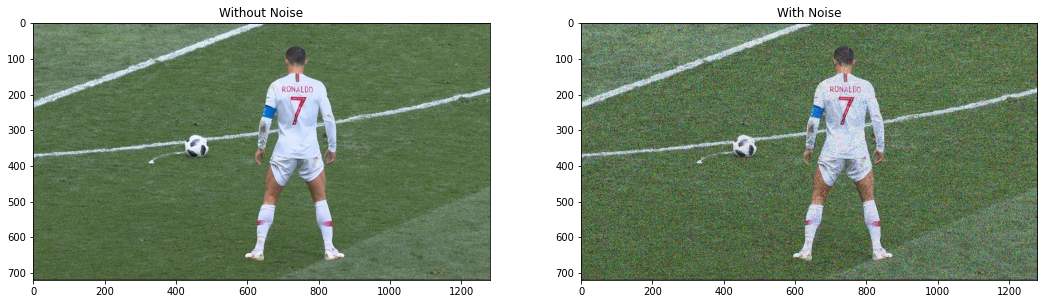

In [ ]:
# Add Noise
img1 = np.copy(Test_Image)
img2 = GaussianNoise(img1)

Visualise(img1,img2,"Results/Gaussian_Noise.png")

Performance

In [ ]:
Accuracy, Accuracy_Gaussian_Noise = Performance(Videos_Path, GaussianNoise)

ApplyEyeMakeup: 100%|██████████| 20/20 [00:33<00:00,  1.66s/it]



Class: ApplyEyeMakeup
Accuracy without GaussianNoise = 0.8
Accuracy with GaussianNoise = 0.8
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




ApplyLipstick: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]



Class: ApplyLipstick
Accuracy without GaussianNoise = 0.9
Accuracy with GaussianNoise = 0.85
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




Archery: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]



Class: Archery
Accuracy without GaussianNoise = 0.95
Accuracy with GaussianNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BabyCrawling: 100%|██████████| 20/20 [00:21<00:00,  1.05s/it]



Class: BabyCrawling
Accuracy without GaussianNoise = 0.85
Accuracy with GaussianNoise = 0.8
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BalanceBeam: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]



Class: BalanceBeam
Accuracy without GaussianNoise = 0.85
Accuracy with GaussianNoise = 0.85
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BandMarching: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]



Class: BandMarching
Accuracy without GaussianNoise = 0.95
Accuracy with GaussianNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BaseballPitch: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]



Class: BaseballPitch
Accuracy without GaussianNoise = 0.9
Accuracy with GaussianNoise = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Basketball: 100%|██████████| 20/20 [00:20<00:00,  1.05s/it]



Class: Basketball
Accuracy without GaussianNoise = 0.95
Accuracy with GaussianNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BasketballDunk: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]



Class: BasketballDunk
Accuracy without GaussianNoise = 1.0
Accuracy with GaussianNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BenchPress: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]



Class: BenchPress
Accuracy without GaussianNoise = 1.0
Accuracy with GaussianNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Biking: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]



Class: Biking
Accuracy without GaussianNoise = 0.95
Accuracy with GaussianNoise = 1.0
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




Billiards: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]



Class: Billiards
Accuracy without GaussianNoise = 1.0
Accuracy with GaussianNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BlowDryHair: 100%|██████████| 20/20 [00:24<00:00,  1.25s/it]



Class: BlowDryHair
Accuracy without GaussianNoise = 0.9
Accuracy with GaussianNoise = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BlowingCandles: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]



Class: BlowingCandles
Accuracy without GaussianNoise = 0.9
Accuracy with GaussianNoise = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BodyWeightSquats: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]



Class: BodyWeightSquats
Accuracy without GaussianNoise = 0.55
Accuracy with GaussianNoise = 0.55
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




Bowling: 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]



Class: Bowling
Accuracy without GaussianNoise = 0.85
Accuracy with GaussianNoise = 0.85
Accuracy between Predictions =  0.9
----------------------------------------------------------------------------------------------------




BoxingPunchingBag: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]



Class: BoxingPunchingBag
Accuracy without GaussianNoise = 1.0
Accuracy with GaussianNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BoxingSpeedBag: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]



Class: BoxingSpeedBag
Accuracy without GaussianNoise = 1.0
Accuracy with GaussianNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BreastStroke: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]



Class: BreastStroke
Accuracy without GaussianNoise = 0.95
Accuracy with GaussianNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BrushingTeeth: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]



Class: BrushingTeeth
Accuracy without GaussianNoise = 0.7
Accuracy with GaussianNoise = 0.65
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




CleanAndJerk: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]



Class: CleanAndJerk
Accuracy without GaussianNoise = 1.0
Accuracy with GaussianNoise = 0.95
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




CliffDiving: 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]



Class: CliffDiving
Accuracy without GaussianNoise = 0.9
Accuracy with GaussianNoise = 0.9
Accuracy between Predictions =  0.9
----------------------------------------------------------------------------------------------------




CricketBowling: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]



Class: CricketBowling
Accuracy without GaussianNoise = 0.9
Accuracy with GaussianNoise = 0.85
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




CricketShot: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]



Class: CricketShot
Accuracy without GaussianNoise = 0.75
Accuracy with GaussianNoise = 0.75
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CuttingInKitchen: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]



Class: CuttingInKitchen
Accuracy without GaussianNoise = 1.0
Accuracy with GaussianNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Diving: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]



Class: Diving
Accuracy without GaussianNoise = 0.95
Accuracy with GaussianNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Drumming: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]



Class: Drumming
Accuracy without GaussianNoise = 0.95
Accuracy with GaussianNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Fencing: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]



Class: Fencing
Accuracy without GaussianNoise = 0.8
Accuracy with GaussianNoise = 0.8
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




FieldHockeyPenalty: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]



Class: FieldHockeyPenalty
Accuracy without GaussianNoise = 0.8
Accuracy with GaussianNoise = 0.8
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




FloorGymnastics: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Class: FloorGymnastics
Accuracy without GaussianNoise = 0.7
Accuracy with GaussianNoise = 0.7
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




## Impact of Salt & Pepper Noise

Salt & Pepper Noise

In [ ]:
def SaltPepperNoise(Input):
    aug = iaa.SaltAndPepper(p=0.2)
    img = aug.augment_image(Input)
    Output = Image.fromarray(img)
    Output = np.clip(Output, 0, 255).astype(int)
    return Output

Visualisation

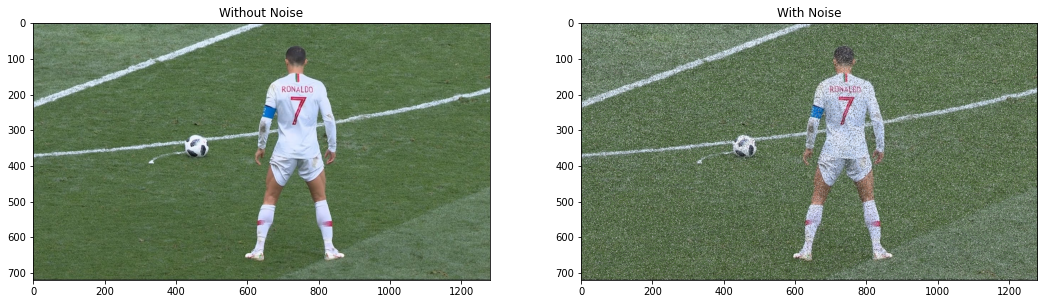

In [ ]:
# Add Noise
img1 = np.copy(Test_Image)
img2 = SaltPepperNoise(img1)

Visualise(img1,img2,"Results/Salt_and_Pepper_Noise.png")

Performance

In [ ]:
Accuracy, Accuracy_SNP_Noise = Performance(Videos_Path, SaltPepperNoise)

ApplyEyeMakeup: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]



Class: ApplyEyeMakeup
Accuracy without SaltPepperNoise = 0.8
Accuracy with SaltPepperNoise = 0.8
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




ApplyLipstick: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]



Class: ApplyLipstick
Accuracy without SaltPepperNoise = 0.85
Accuracy with SaltPepperNoise = 0.85
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Archery: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]



Class: Archery
Accuracy without SaltPepperNoise = 0.95
Accuracy with SaltPepperNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BabyCrawling: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]



Class: BabyCrawling
Accuracy without SaltPepperNoise = 0.8
Accuracy with SaltPepperNoise = 0.75
Accuracy between Predictions =  0.85
----------------------------------------------------------------------------------------------------




BalanceBeam: 100%|██████████| 20/20 [00:09<00:00,  2.00it/s]



Class: BalanceBeam
Accuracy without SaltPepperNoise = 0.8
Accuracy with SaltPepperNoise = 0.8
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BandMarching: 100%|██████████| 20/20 [00:11<00:00,  1.70it/s]



Class: BandMarching
Accuracy without SaltPepperNoise = 0.95
Accuracy with SaltPepperNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BaseballPitch: 100%|██████████| 20/20 [00:09<00:00,  2.08it/s]



Class: BaseballPitch
Accuracy without SaltPepperNoise = 0.95
Accuracy with SaltPepperNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Basketball: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]



Class: Basketball
Accuracy without SaltPepperNoise = 0.95
Accuracy with SaltPepperNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BasketballDunk: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]



Class: BasketballDunk
Accuracy without SaltPepperNoise = 1.0
Accuracy with SaltPepperNoise = 0.9
Accuracy between Predictions =  0.9
----------------------------------------------------------------------------------------------------




BenchPress: 100%|██████████| 20/20 [00:09<00:00,  2.00it/s]



Class: BenchPress
Accuracy without SaltPepperNoise = 1.0
Accuracy with SaltPepperNoise = 0.95
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




Biking: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]



Class: Biking
Accuracy without SaltPepperNoise = 0.9
Accuracy with SaltPepperNoise = 0.95
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




Billiards: 100%|██████████| 20/20 [00:11<00:00,  1.67it/s]



Class: Billiards
Accuracy without SaltPepperNoise = 1.0
Accuracy with SaltPepperNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BlowDryHair: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]



Class: BlowDryHair
Accuracy without SaltPepperNoise = 0.95
Accuracy with SaltPepperNoise = 0.95
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BlowingCandles: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]



Class: BlowingCandles
Accuracy without SaltPepperNoise = 0.9
Accuracy with SaltPepperNoise = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BodyWeightSquats: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]



Class: BodyWeightSquats
Accuracy without SaltPepperNoise = 0.65
Accuracy with SaltPepperNoise = 0.65
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




Bowling: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]



Class: Bowling
Accuracy without SaltPepperNoise = 0.95
Accuracy with SaltPepperNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BoxingPunchingBag: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]



Class: BoxingPunchingBag
Accuracy without SaltPepperNoise = 0.95
Accuracy with SaltPepperNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BoxingSpeedBag: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]



Class: BoxingSpeedBag
Accuracy without SaltPepperNoise = 1.0
Accuracy with SaltPepperNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BreastStroke: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]



Class: BreastStroke
Accuracy without SaltPepperNoise = 1.0
Accuracy with SaltPepperNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BrushingTeeth: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]



Class: BrushingTeeth
Accuracy without SaltPepperNoise = 0.65
Accuracy with SaltPepperNoise = 0.65
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CleanAndJerk: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]



Class: CleanAndJerk
Accuracy without SaltPepperNoise = 1.0
Accuracy with SaltPepperNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CliffDiving: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]



Class: CliffDiving
Accuracy without SaltPepperNoise = 0.9
Accuracy with SaltPepperNoise = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CricketBowling: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]



Class: CricketBowling
Accuracy without SaltPepperNoise = 0.85
Accuracy with SaltPepperNoise = 0.8
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




CricketShot: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]



Class: CricketShot
Accuracy without SaltPepperNoise = 0.7
Accuracy with SaltPepperNoise = 0.7
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CuttingInKitchen: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]



Class: CuttingInKitchen
Accuracy without SaltPepperNoise = 1.0
Accuracy with SaltPepperNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Diving: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]



Class: Diving
Accuracy without SaltPepperNoise = 1.0
Accuracy with SaltPepperNoise = 0.95
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




Drumming: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]



Class: Drumming
Accuracy without SaltPepperNoise = 0.95
Accuracy with SaltPepperNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Fencing: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]



Class: Fencing
Accuracy without SaltPepperNoise = 0.8
Accuracy with SaltPepperNoise = 0.8
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




FieldHockeyPenalty: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]



Class: FieldHockeyPenalty
Accuracy without SaltPepperNoise = 0.8
Accuracy with SaltPepperNoise = 0.85
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




FloorGymnastics: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Class: FloorGymnastics
Accuracy without SaltPepperNoise = 0.7
Accuracy with SaltPepperNoise = 0.7
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




## Impact of Shot Noise

Shot Noise

In [ ]:
def ShotNoise(Input, mu=0, sigma=5):
    Poisson_Noise = np.sqrt(Input) * np.random.normal(mu, sigma, Input.shape)
    Output = np.clip(Input + Poisson_Noise, 0, 255).astype(int)
    return Output

Visualisation

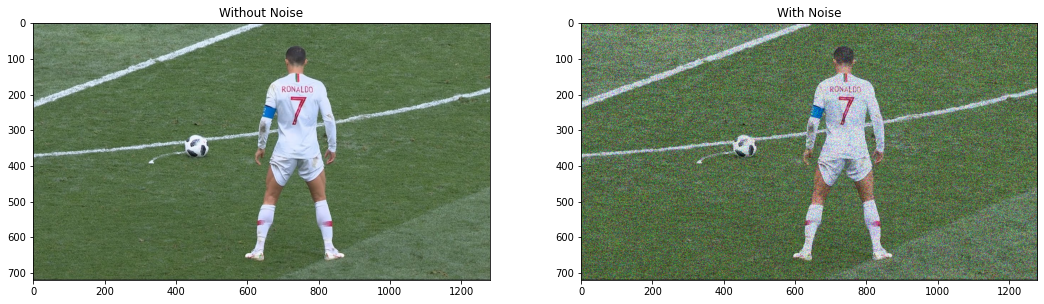

In [ ]:
# Add Noise
img1 = np.copy(Test_Image)
img2 = ShotNoise(img1)

Visualise(img1,img2,"Results/Shot_Noise.png")

Performance

In [ ]:
Accuracy, Accuracy_Shot_Noise = Performance(Videos_Path, ShotNoise)

ApplyEyeMakeup: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]



Class: ApplyEyeMakeup
Accuracy without ShotNoise = 0.85
Accuracy with ShotNoise = 0.85
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




ApplyLipstick: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]



Class: ApplyLipstick
Accuracy without ShotNoise = 0.9
Accuracy with ShotNoise = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Archery: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]



Class: Archery
Accuracy without ShotNoise = 1.0
Accuracy with ShotNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BabyCrawling: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]



Class: BabyCrawling
Accuracy without ShotNoise = 0.65
Accuracy with ShotNoise = 0.65
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BalanceBeam: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]



Class: BalanceBeam
Accuracy without ShotNoise = 0.8
Accuracy with ShotNoise = 0.8
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BandMarching: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]



Class: BandMarching
Accuracy without ShotNoise = 0.95
Accuracy with ShotNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BaseballPitch: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]



Class: BaseballPitch
Accuracy without ShotNoise = 0.95
Accuracy with ShotNoise = 0.9
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




Basketball: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]



Class: Basketball
Accuracy without ShotNoise = 0.9
Accuracy with ShotNoise = 0.9
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BasketballDunk: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]



Class: BasketballDunk
Accuracy without ShotNoise = 0.95
Accuracy with ShotNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BenchPress: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]



Class: BenchPress
Accuracy without ShotNoise = 1.0
Accuracy with ShotNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Biking: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]



Class: Biking
Accuracy without ShotNoise = 0.95
Accuracy with ShotNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Billiards: 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]



Class: Billiards
Accuracy without ShotNoise = 1.0
Accuracy with ShotNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BlowDryHair: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]



Class: BlowDryHair
Accuracy without ShotNoise = 0.9
Accuracy with ShotNoise = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BlowingCandles: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]



Class: BlowingCandles
Accuracy without ShotNoise = 0.9
Accuracy with ShotNoise = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BodyWeightSquats: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]



Class: BodyWeightSquats
Accuracy without ShotNoise = 0.55
Accuracy with ShotNoise = 0.55
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Bowling: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]



Class: Bowling
Accuracy without ShotNoise = 0.95
Accuracy with ShotNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BoxingPunchingBag: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]



Class: BoxingPunchingBag
Accuracy without ShotNoise = 0.95
Accuracy with ShotNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BoxingSpeedBag: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]



Class: BoxingSpeedBag
Accuracy without ShotNoise = 1.0
Accuracy with ShotNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BreastStroke: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]



Class: BreastStroke
Accuracy without ShotNoise = 1.0
Accuracy with ShotNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BrushingTeeth: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]



Class: BrushingTeeth
Accuracy without ShotNoise = 0.65
Accuracy with ShotNoise = 0.65
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CleanAndJerk: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]



Class: CleanAndJerk
Accuracy without ShotNoise = 1.0
Accuracy with ShotNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CliffDiving: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]



Class: CliffDiving
Accuracy without ShotNoise = 0.8
Accuracy with ShotNoise = 0.85
Accuracy between Predictions =  0.9
----------------------------------------------------------------------------------------------------




CricketBowling: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s]



Class: CricketBowling
Accuracy without ShotNoise = 0.9
Accuracy with ShotNoise = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CricketShot: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]



Class: CricketShot
Accuracy without ShotNoise = 0.7
Accuracy with ShotNoise = 0.7
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CuttingInKitchen: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]



Class: CuttingInKitchen
Accuracy without ShotNoise = 1.0
Accuracy with ShotNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Diving: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]



Class: Diving
Accuracy without ShotNoise = 1.0
Accuracy with ShotNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Drumming: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]



Class: Drumming
Accuracy without ShotNoise = 0.95
Accuracy with ShotNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Fencing: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]



Class: Fencing
Accuracy without ShotNoise = 0.8
Accuracy with ShotNoise = 0.8
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




FieldHockeyPenalty: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]



Class: FieldHockeyPenalty
Accuracy without ShotNoise = 0.8
Accuracy with ShotNoise = 0.75
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




FloorGymnastics: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Class: FloorGymnastics
Accuracy without ShotNoise = 0.75
Accuracy with ShotNoise = 0.75
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




## Impact of Periodic Noise

Periodic Noise

In [ ]:
def PeriodicNoise(Input):
    l,m = Input.shape[0], Input.shape[1]
    X, Y = np.meshgrid(range(0, m), range(0, l))

    A = 100
    u = 8
    v = 8
    Noise = A*np.cos(X*(2*np.pi*u/m) + Y*(2*np.pi*v/l))
    
    Channel1 = Input[:,:,0] + Noise/3.0
    Channel2 = Input[:,:,1] + Noise/3.0
    Channel3 = Input[:,:,2] + Noise/3.0

    Output = np.clip(np.stack((Channel1,Channel2,Channel3),axis=2), 0, 255).astype(int)

    return Output

Visualisation

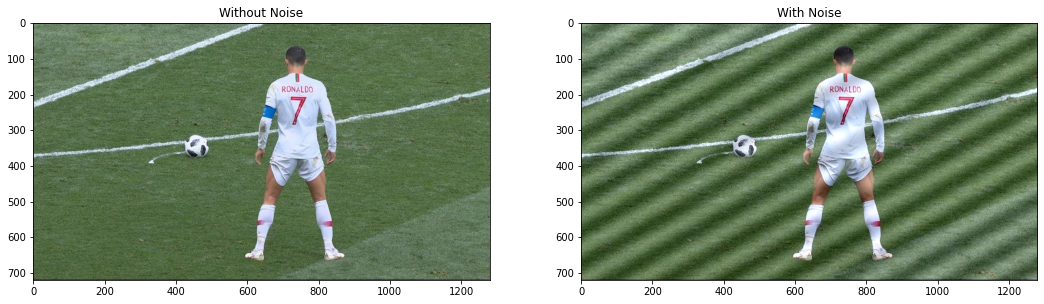

In [ ]:
# Add Noise
img1 = np.copy(Test_Image)
img2 = PeriodicNoise(img1)

Visualise(img1,img2,"Results/Perioidc_Noise.png")

Performance

In [ ]:
Accuracy, Accuracy_Periodic_Noise = Performance(Videos_Path, PeriodicNoise)

ApplyEyeMakeup: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]



Class: ApplyEyeMakeup
Accuracy without PeriodicNoise = 0.8
Accuracy with PeriodicNoise = 0.8
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




ApplyLipstick: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]



Class: ApplyLipstick
Accuracy without PeriodicNoise = 0.85
Accuracy with PeriodicNoise = 0.85
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Archery: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]



Class: Archery
Accuracy without PeriodicNoise = 0.95
Accuracy with PeriodicNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BabyCrawling: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]



Class: BabyCrawling
Accuracy without PeriodicNoise = 0.85
Accuracy with PeriodicNoise = 0.9
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BalanceBeam: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]



Class: BalanceBeam
Accuracy without PeriodicNoise = 0.85
Accuracy with PeriodicNoise = 0.85
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BandMarching: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]



Class: BandMarching
Accuracy without PeriodicNoise = 0.9
Accuracy with PeriodicNoise = 0.95
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BaseballPitch: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]



Class: BaseballPitch
Accuracy without PeriodicNoise = 0.9
Accuracy with PeriodicNoise = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Basketball: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]



Class: Basketball
Accuracy without PeriodicNoise = 0.9
Accuracy with PeriodicNoise = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BasketballDunk: 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]



Class: BasketballDunk
Accuracy without PeriodicNoise = 1.0
Accuracy with PeriodicNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BenchPress: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]



Class: BenchPress
Accuracy without PeriodicNoise = 1.0
Accuracy with PeriodicNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Biking: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]



Class: Biking
Accuracy without PeriodicNoise = 0.9
Accuracy with PeriodicNoise = 0.85
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




Billiards: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]



Class: Billiards
Accuracy without PeriodicNoise = 1.0
Accuracy with PeriodicNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BlowDryHair: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]



Class: BlowDryHair
Accuracy without PeriodicNoise = 0.9
Accuracy with PeriodicNoise = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BlowingCandles: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]



Class: BlowingCandles
Accuracy without PeriodicNoise = 0.9
Accuracy with PeriodicNoise = 0.85
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BodyWeightSquats: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]



Class: BodyWeightSquats
Accuracy without PeriodicNoise = 0.6
Accuracy with PeriodicNoise = 0.6
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Bowling: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]



Class: Bowling
Accuracy without PeriodicNoise = 0.9
Accuracy with PeriodicNoise = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BoxingPunchingBag: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]



Class: BoxingPunchingBag
Accuracy without PeriodicNoise = 1.0
Accuracy with PeriodicNoise = 0.95
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BoxingSpeedBag: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]



Class: BoxingSpeedBag
Accuracy without PeriodicNoise = 1.0
Accuracy with PeriodicNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BreastStroke: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]



Class: BreastStroke
Accuracy without PeriodicNoise = 1.0
Accuracy with PeriodicNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BrushingTeeth: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]



Class: BrushingTeeth
Accuracy without PeriodicNoise = 0.65
Accuracy with PeriodicNoise = 0.7
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




CleanAndJerk: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]



Class: CleanAndJerk
Accuracy without PeriodicNoise = 1.0
Accuracy with PeriodicNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CliffDiving: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]



Class: CliffDiving
Accuracy without PeriodicNoise = 0.9
Accuracy with PeriodicNoise = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CricketBowling: 100%|██████████| 20/20 [00:09<00:00,  2.08it/s]



Class: CricketBowling
Accuracy without PeriodicNoise = 0.9
Accuracy with PeriodicNoise = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CricketShot: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s]



Class: CricketShot
Accuracy without PeriodicNoise = 0.75
Accuracy with PeriodicNoise = 0.75
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CuttingInKitchen: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]



Class: CuttingInKitchen
Accuracy without PeriodicNoise = 1.0
Accuracy with PeriodicNoise = 0.95
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




Diving: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]



Class: Diving
Accuracy without PeriodicNoise = 1.0
Accuracy with PeriodicNoise = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Drumming: 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]



Class: Drumming
Accuracy without PeriodicNoise = 0.95
Accuracy with PeriodicNoise = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Fencing: 100%|██████████| 20/20 [00:09<00:00,  2.00it/s]



Class: Fencing
Accuracy without PeriodicNoise = 0.8
Accuracy with PeriodicNoise = 0.8
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




FieldHockeyPenalty: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]



Class: FieldHockeyPenalty
Accuracy without PeriodicNoise = 0.8
Accuracy with PeriodicNoise = 0.8
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




FloorGymnastics: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Class: FloorGymnastics
Accuracy without PeriodicNoise = 0.7
Accuracy with PeriodicNoise = 0.7
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




## Plotting Results

Results

In [ ]:
Results = [(Accuracy, "Without Noise"),
           (Accuracy_Gaussian_Noise, "Gaussian Noise"),
           (Accuracy_SNP_Noise, "Salt and Pepper Noise"),
           (Accuracy_Shot_Noise, "Shot Noise"),
           (Accuracy_Shot_Noise, "Periodic Noise")]

Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


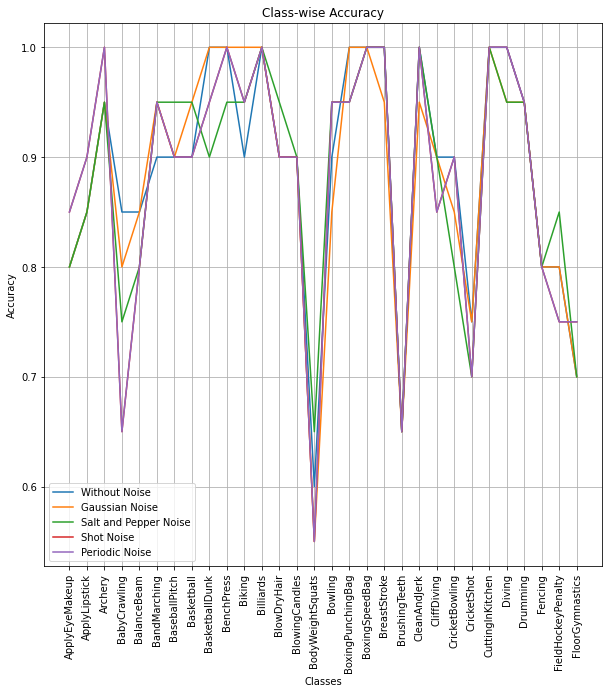

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Class-wise Accuracy")
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.grid()
X = np.arange(N)
plt.xticks(X, Classes, rotation=90)
for Acc, Desc in Results:
    plt.plot(X, Acc, label=Desc)
plt.legend()
plt.savefig("Results/Image_Noise.eps")
plt.show()